In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.6 MB/s eta 0:00:00


In [49]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import utils
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from transformers import PreTrainedTokenizerFast
import torchvision.models
from torchsummary import summary

# 시각화 관련
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 
from tqdm.notebook import tqdm
from PIL import Image

# arange 기본
import numpy as np
import pandas as pd

# 그외
import os
import random
import tqdm
from glob import glob

In [ ]:
# 그라디오
!pip install gradio -q

In [5]:
import gradio as gr

def greet(name):
    return 'hello ' + name + '!'

demo = gr.Interface(
    fn = greet,
    inputs = gr.Textbox(lines=2, placeholder='Name Her...'),
    outputs='text',
)
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [6]:
USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [10]:
# 캐글 json으로 산타클로스 데이터 불러오기
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 87% 177M/203M [00:01<00:00, 130MB/s]
100% 203M/203M [00:01<00:00, 136MB/s]


In [11]:
!unzip /content/is-that-santa-image-classification.zip

Archive:  /content/is-that-santa-image-classification.zip
  inflating: is that santa/test/not-a-santa/0.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/1.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/100.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/103.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/104.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/105.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/107.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/109.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/110.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/111.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/113.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/114.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/115.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/116.not-a-santa.jpg  
  inflating: is that s

In [26]:
santa_imgs = ImageFolder('/content/is that santa/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(80),
                             transforms.ToTensor()]))
train_loader = DataLoader(santa_imgs, batch_size = 1, shuffle = True)

In [13]:
santa_imgs[0][0].shape

torch.Size([3, 80, 80])

# 산타 이미지를 불러와요

In [54]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data = data_path
        self.label = [int(p.split('/')[-2] == 'santa') for p in data_path]
        self.data_len = len(self.data)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        image = Image.open(self.data[index], mode='r')
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        self.label[index] = np.array(self.label[index])
        return image, torch.from_numpy(self.label[index])

In [55]:
train_mother_path = '/content/is that santa/train/'
test_mother_path = '/content/is that santa/test/'

train_image_path = glob(os.path.join(train_mother_path, '*', '*'))
test_image_path = glob(os.path.join(test_mother_path, '*', '*'))

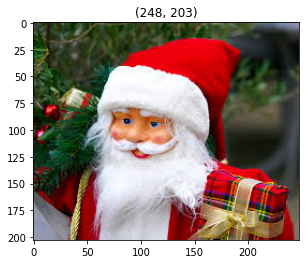

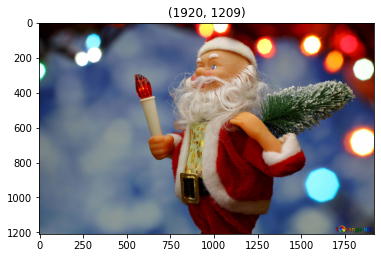

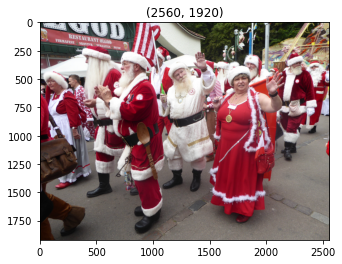

In [33]:
for _ in range(3):
    idx = np.random.randint(0, len(train_image_path))
    image = Image.open(train_image_path[idx])
    plt.imshow(image)
    plt.title(image.size)
    plt.show()

In [57]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

In [58]:
BATCH_SIZE = 64

trainLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [59]:
def train(model, trainLoader):
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [60]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [61]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.MaxPool2d(kernel_size=3, stride=2)
                                    )
       
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.MaxPool2d(kernel_size=3, stride=2)
                                    )

        self.fc = nn.Linear(186624, 2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [62]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

In [63]:
%%time
# 시간체크 5분 예상
N_EPOCH = 5

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(cnn, trainLoader)
    val_loss, val_accuracy = test(cnn, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))
    

EPOCH 1
     Train | Loss :  0.6769, Accuracy :  82.74 %
Validation | Loss :  0.3982, Accuracy :  82.47 %

EPOCH 2
     Train | Loss :  0.2205, Accuracy :  94.30 %
Validation | Loss :  0.3545, Accuracy :  85.55 %

EPOCH 3
     Train | Loss :  0.1064, Accuracy :  96.91 %
Validation | Loss :  0.3453, Accuracy :  89.12 %

EPOCH 4
     Train | Loss :  0.0222, Accuracy :  98.86 %
Validation | Loss :  0.4919, Accuracy :  90.26 %

EPOCH 5
     Train | Loss :  0.0030, Accuracy : 100.00 %
Validation | Loss :  0.5730, Accuracy :  89.77 %

CPU times: user 1min 40s, sys: 621 ms, total: 1min 41s
Wall time: 1min 41s


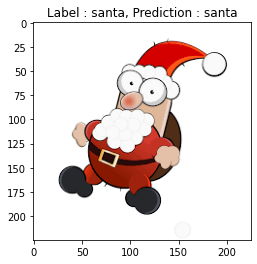

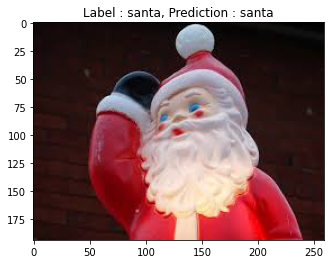

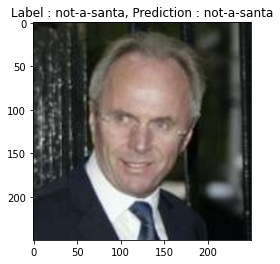

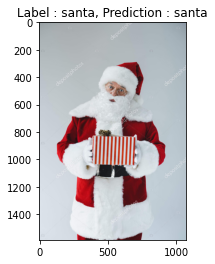

In [69]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]
    
    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)
    
    prediction = cnn(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    plt.imshow(image)
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.show()

In [70]:
# Use pretrained GoogLeNet
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet.fc.out_features = 2
googlenet = googlenet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [71]:
summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=1e-3)

In [73]:
%%time
N_EPOCH = 5

for epoch in range(1, N_EPOCH+1):

    loss, accuracy = train(googlenet, trainLoader)
    val_loss, val_accuracy = test(googlenet, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

     Train | Loss :  1.8437, Accuracy :  77.04 %
Validation | Loss :  1.2314, Accuracy :  91.40 %

     Train | Loss :  0.1189, Accuracy :  96.91 %
Validation | Loss :  0.2205, Accuracy :  95.45 %

     Train | Loss :  0.1352, Accuracy :  96.09 %
Validation | Loss :  0.1428, Accuracy :  95.78 %

     Train | Loss :  0.0578, Accuracy :  98.37 %
Validation | Loss :  0.1771, Accuracy :  95.45 %

     Train | Loss :  0.0337, Accuracy :  98.86 %
Validation | Loss :  0.1919, Accuracy :  93.34 %

CPU times: user 1min 44s, sys: 5.22 s, total: 1min 49s
Wall time: 1min 48s


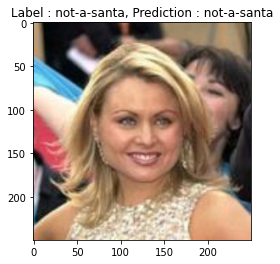

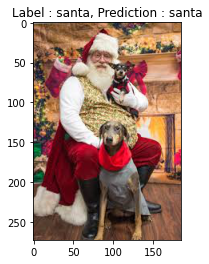

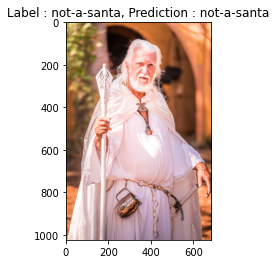

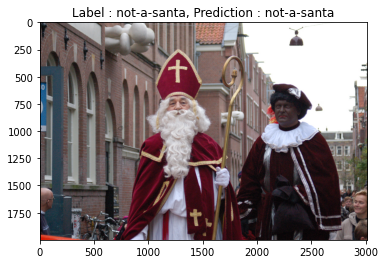

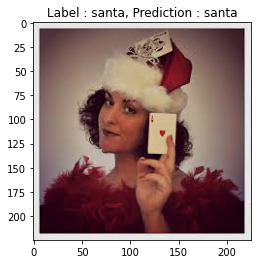

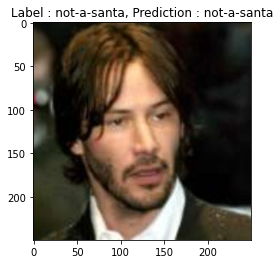

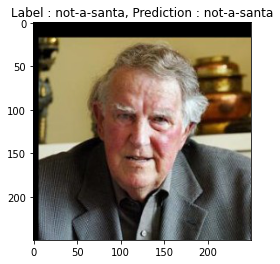

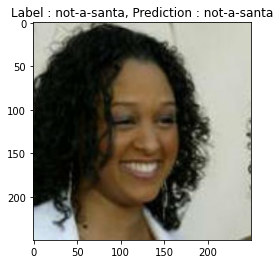

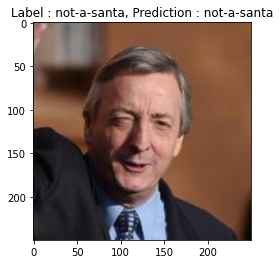

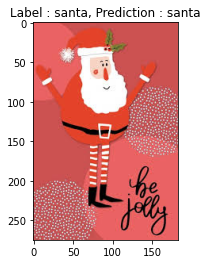

In [74]:
for _ in range(10):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]

    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)

    prediction = googlenet(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.imshow(image)
    plt.show()

# googlenet 종료/ 타 모델 호출

# Resnet

In [75]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)
BATCH_SIZE = 64

trainLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [76]:
def train(model, trainLoader):
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [77]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [78]:
class BasicBlock(nn.Module):
   def __init__(self, in_planes, planes, stride = 1):
       super(BasicBlock, self).__init__() 
       self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
       self.bn1 = nn.BatchNorm2d(planes)
       self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding =1 , bias = False)
       self.bn2 = nn.BatchNorm2d(planes)
       self.shortcut = nn.Sequential()
       if stride != 1 or in_planes != planes:
          self.shortcut = nn.Sequential( 
              nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False)  
              , nn.BatchNorm2d(planes)
              )
   def forward(self, x):

       out = F.relu(self.bn1(self.conv1(x)))
       out - self.bn2(self.conv2(out))
       out = out+self.shortcut(x)
       out = F.relu(out)

       return out

In [79]:
class ResNet(nn.Module):
   def __init__(self, num_classes = 10):
       super(ResNet, self).__init__()
       self.in_planes = 16
       self.conv1 = nn.Conv2d(3,16, kernel_size = 3, stride = 1, padding = 1 , bias = False) 
       self.bn1 = nn.BatchNorm2d(16)

       self.layer1 = self._make_layer(16, 2, stride = 1) 
       self.layer2 = self._make_layer(32, 2, stride = 2) 
       self.layer3 = self._make_layer(64, 2, stride = 2) 
       self.linear = nn.Linear(64, num_classes)

   def _make_layer(self, planes, num_blocks, stride):

       strides = [stride] + [1] * (num_blocks -1)
       layers = []
       for stride in strides:
           layers.append(BasicBlock(self.in_planes, planes, stride)) 
           self.in_planes = planes
       return nn.Sequential(*layers)
   
   def forward(self, x):
       out = F.relu(self.bn1(self.conv1(x)))
       out = self.layer1(out)
       out = self.layer2(out)
       out = self.layer3(out)

       out = F.avg_pool2d(out, 8)
       out = out.view(out.size(0), -1)
       out = self.linear(out)

       return out

In [81]:
# Resnet 호출
!wget https://github.com/bigdata-young/ai_26th/raw/main/etc/resnet.pt

model = ResNet().to(device)
model.load_state_dict(torch.load('/content/resnet.pt'))

--2023-01-27 01:11:30--  https://github.com/bigdata-young/ai_26th/raw/main/etc/resnet.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/resnet.pt [following]
--2023-01-27 01:11:30--  https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/resnet.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730291 (713K) [application/octet-stream]
Saving to: ‘resnet.pt.4’

resnet.pt.4         100%[===================>] 713.17K  --.-KB/s    in 0.04s   

2023-01-27 01:11:30 (15.5 MB/s) - ‘resnet.pt.4’ saved [730291/730291]



<All keys matched successfully>

In [82]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [83]:
from torchsummary import summary as summary_

summary_(model, (3, 32, 32), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 32, 32]             432
       BatchNorm2d-2          [128, 16, 32, 32]              32
            Conv2d-3          [128, 16, 32, 32]           2,304
       BatchNorm2d-4          [128, 16, 32, 32]              32
            Conv2d-5          [128, 16, 32, 32]           2,304
       BatchNorm2d-6          [128, 16, 32, 32]              32
        BasicBlock-7          [128, 16, 32, 32]               0
            Conv2d-8          [128, 16, 32, 32]           2,304
       BatchNorm2d-9          [128, 16, 32, 32]              32
           Conv2d-10          [128, 16, 32, 32]           2,304
      BatchNorm2d-11          [128, 16, 32, 32]              32
       BasicBlock-12          [128, 16, 32, 32]               0
           Conv2d-13          [128, 32, 16, 16]           4,608
      BatchNorm2d-14          [128, 32,

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [85]:
# epoch 5회, resnet으로 진행
%%time
EPOCH = 5


for epoch in range(1, EPOCH+1):

    loss, accuracy = train(model, trainLoader)
    val_loss, val_accuracy = test(model, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

     Train | Loss :  1.8922, Accuracy :  58.31 %
Validation | Loss :  1.3801, Accuracy :  55.52 %

     Train | Loss :  1.2876, Accuracy :  79.64 %
Validation | Loss :  0.8842, Accuracy :  77.44 %

     Train | Loss :  0.9313, Accuracy :  84.53 %
Validation | Loss :  0.6033, Accuracy :  85.88 %

     Train | Loss :  0.6897, Accuracy :  87.95 %
Validation | Loss :  0.4921, Accuracy :  88.80 %

     Train | Loss :  0.5406, Accuracy :  89.90 %
Validation | Loss :  0.4609, Accuracy :  89.77 %

CPU times: user 1min 27s, sys: 730 ms, total: 1min 28s
Wall time: 1min 30s


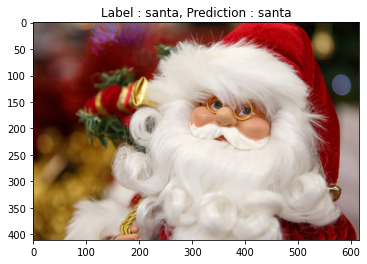

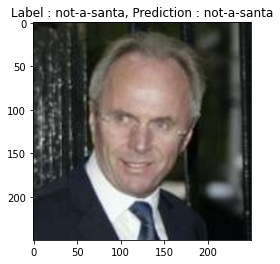

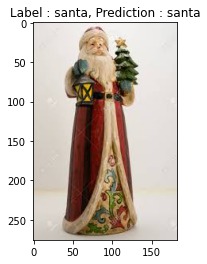

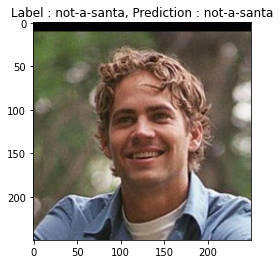

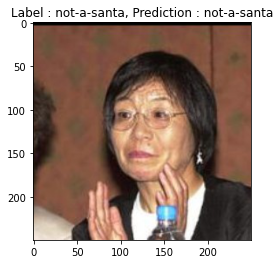

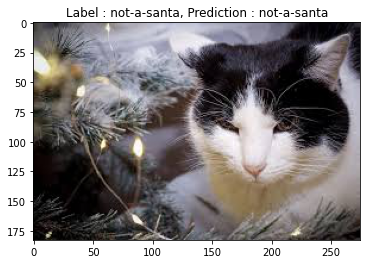

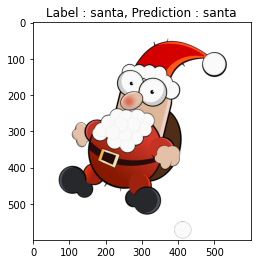

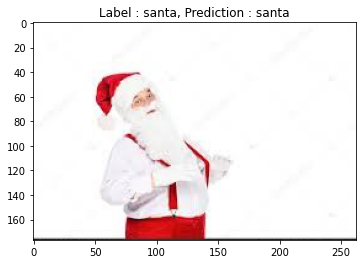

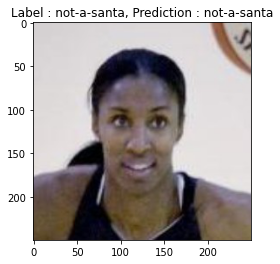

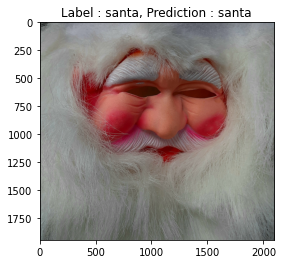

In [86]:
for _ in range(10):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]

    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)

    prediction = model(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.imshow(image)
    plt.show()

# new model - resnet18

In [ ]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)
BATCH_SIZE = 64

trainLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [ ]:
def train(model, trainLoader):
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [ ]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [ ]:
class BasicBlock(nn.Module):
   def __init__(self, in_planes, planes, stride = 1):
       super(BasicBlock, self).__init__() 
       self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
       self.bn1 = nn.BatchNorm2d(planes)
       self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding =1 , bias = False)
       self.bn2 = nn.BatchNorm2d(planes)
       self.shortcut = nn.Sequential()
       if stride != 1 or in_planes != planes:
          self.shortcut = nn.Sequential( 
              nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False)  
              , nn.BatchNorm2d(planes)
              )
   def forward(self, x):

       out = F.relu(self.bn1(self.conv1(x)))
       out - self.bn2(self.conv2(out))
       out = out+self.shortcut(x)
       out = F.relu(out)

       return out

In [ ]:
class ResNet(nn.Module):
   def __init__(self, num_classes = 10):
       super(ResNet, self).__init__()
       self.in_planes = 16
       self.conv1 = nn.Conv2d(3,16, kernel_size = 3, stride = 1, padding = 1 , bias = False) 
       self.bn1 = nn.BatchNorm2d(16)

       self.layer1 = self._make_layer(16, 2, stride = 1) 
       self.layer2 = self._make_layer(32, 2, stride = 2) 
       self.layer3 = self._make_layer(64, 2, stride = 2) 
       self.linear = nn.Linear(64, num_classes)

   def _make_layer(self, planes, num_blocks, stride):

       strides = [stride] + [1] * (num_blocks -1)
       layers = []
       for stride in strides:
           layers.append(BasicBlock(self.in_planes, planes, stride)) 
           self.in_planes = planes
       return nn.Sequential(*layers)
   
   def forward(self, x):
       out = F.relu(self.bn1(self.conv1(x)))
       out = self.layer1(out)
       out = self.layer2(out)
       out = self.layer3(out)

       out = F.avg_pool2d(out, 8)
       out = out.view(out.size(0), -1)
       out = self.linear(out)

       return out

In [100]:
# Resnet 호출

from torchvision import models

resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
num_classes = 10
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda')
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [103]:
# summary
summary_(resnet18, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# epoch 20회, resnet18으로 진행
# 시간소요 체크
%%time
EPOCH = 20

for epoch in range(1, EPOCH+1):

    loss, accuracy = train(resnet18, trainLoader)
    val_loss, val_accuracy = test(resnet18, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

     Train | Loss :  2.8696, Accuracy :   2.61 %
Validation | Loss :  2.3764, Accuracy :   5.68 %

     Train | Loss :  2.8794, Accuracy :   2.44 %
Validation | Loss :  2.4832, Accuracy :   4.06 %

     Train | Loss :  2.8673, Accuracy :   2.61 %
Validation | Loss :  2.6499, Accuracy :   2.11 %

